# Application of SGP model to analytical test case

<div class="jumbotron text-left"><b>
The French Aerospace Lab ONERA <br/>
Information Processing and Systems Department (DTIS) <br/>
Multidisciplinary Methods, Integrated Concepts (M2CI) Research Unit <br/>
</div>
    
**Latest update:** December 2023 - Hugo Valayer \& Nathalie Bartoli 

## I- Useful libraries

### Import

In [1]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# Sparse GP regression model
from smt.surrogate_models import SGP

# Complete GP
from smt.surrogate_models import KRG

In [2]:
# Set seed via random generator for reproducibility
rng = np.random.RandomState(0)

## 1 - Define benchmark problem
### 1.1 Target function

$$\forall x\in[-1,1]\;,\;f(x)=\sin(3\pi x) + 0.3\cos(9\pi x) + 0.5\sin(7\pi x)$$

In [3]:
def f_obj(x):
    return (
        np.sin(3 * np.pi * x)
        + 0.3 * np.cos(9 * np.pi * x)
        + 0.5 * np.sin(7 * np.pi * x)
    )

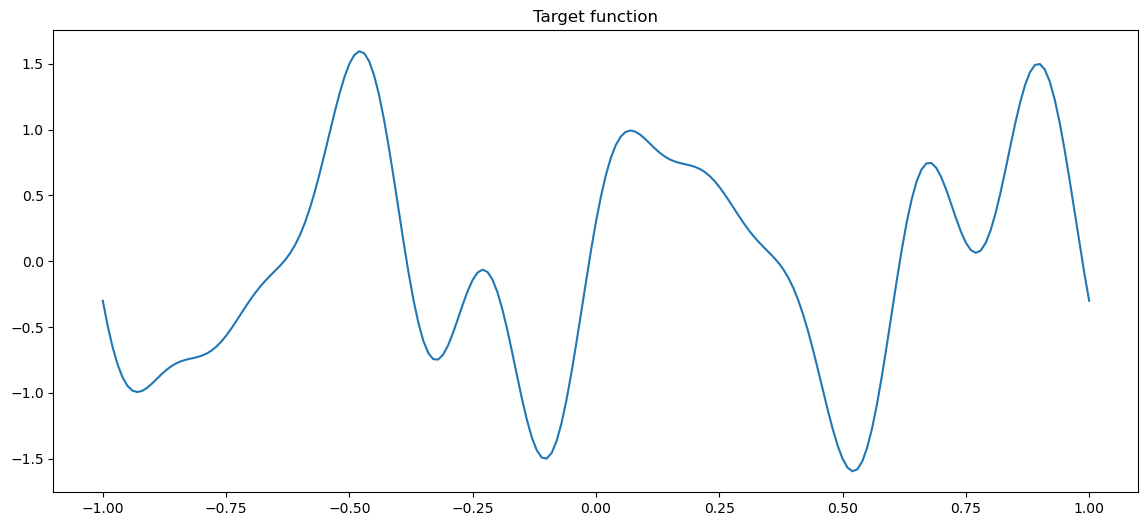

In [4]:
x = np.linspace(-1, 1, 201).reshape(-1, 1)
y = f_obj(x)

plt.figure(figsize=(14, 6))
plt.plot(x, y)
plt.xlim([-1.1, 1.1])
plt.title("Target function")
plt.show()

### 1.2 Dataset: training and validation 

In [5]:
# number of observations
N = 200

# noise
eta = 0.01

# generate data
xt = 2 * np.random.rand(N, 1) - 1
yt = f_obj(xt) + rng.normal(loc=0.0, scale=np.sqrt(eta), size=(N, 1))

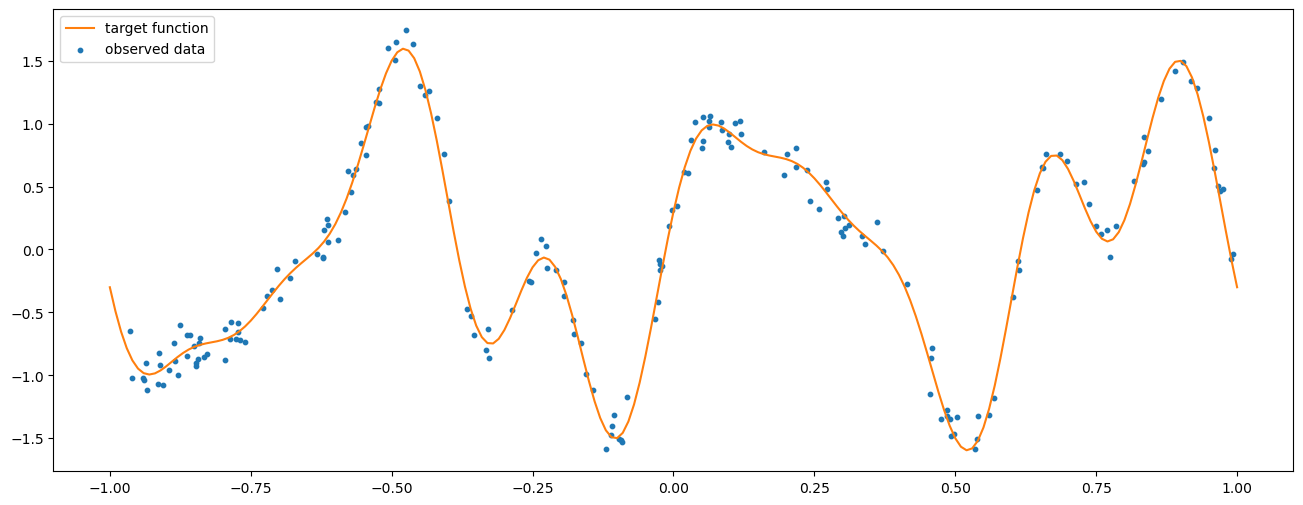

In [6]:
savename = "FIG_ANALYTIC/sparse1D_doe.png"
plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.xlim([-1.1, 1.1])
plt.legend(loc=0)
plt.savefig(savename)
plt.show()

In [7]:
# generate data
Ntest = 1000
xtest = 2 * np.random.rand(Ntest, 1) - 1
ytest = f_obj(xtest) + rng.normal(loc=0.0, scale=np.sqrt(eta), size=(Ntest, 1))

### 1.3 Inducing points chosen randomly from training points

In [8]:
# Pick inducing points randomly in training data
n_inducing = 30
random_idx = rng.permutation(N)[:n_inducing]
Z1 = xt[random_idx].copy()

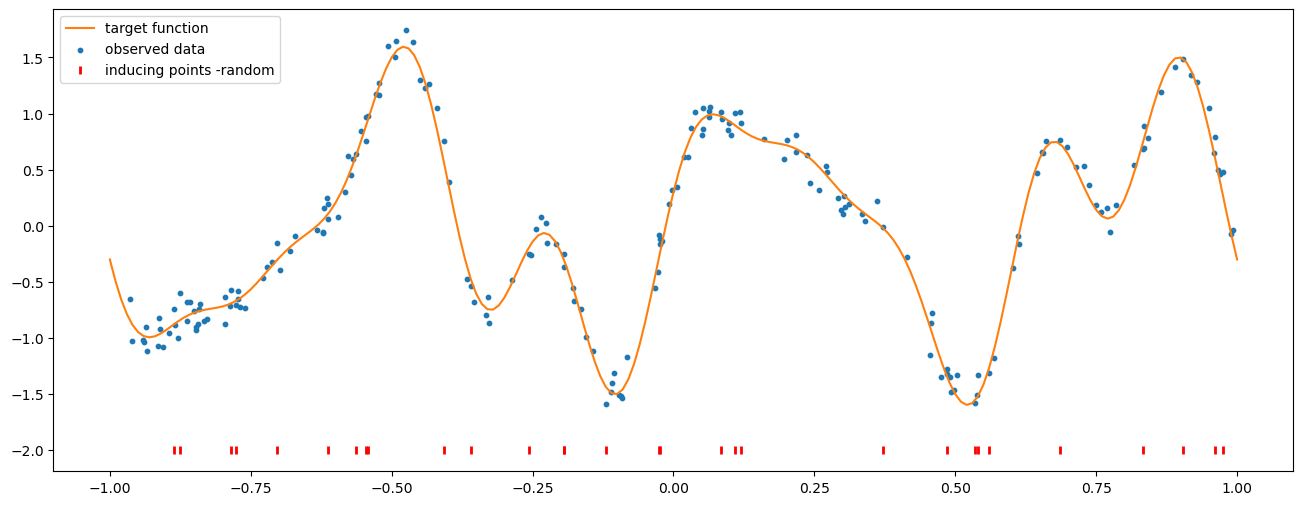

In [9]:
# plot
savename = "FIG_ANALYTIC/sparse1D_M30_random_inducing.png"
plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(Z1, -2.0 * np.ones_like(Z1), "r|", mew=2, label="inducing points -random")
plt.xlim([-1.1, 1.1])
plt.legend(loc=0)
plt.savefig(savename)
plt.show()

### 1.4 Inducing points chosen from K-means

In [10]:
from scipy.cluster.vq import kmeans

# Define inducing inputs as centroids of k-means clusters over (X,Y)
data = np.hstack((xt, yt))

# Perform k-means
start = time.time()
Z2 = kmeans(data, n_inducing)[0][:, :-1]
elapsed = time.time() - start
print("k-means computation time: %.2fs" % elapsed)

k-means computation time: 0.01s


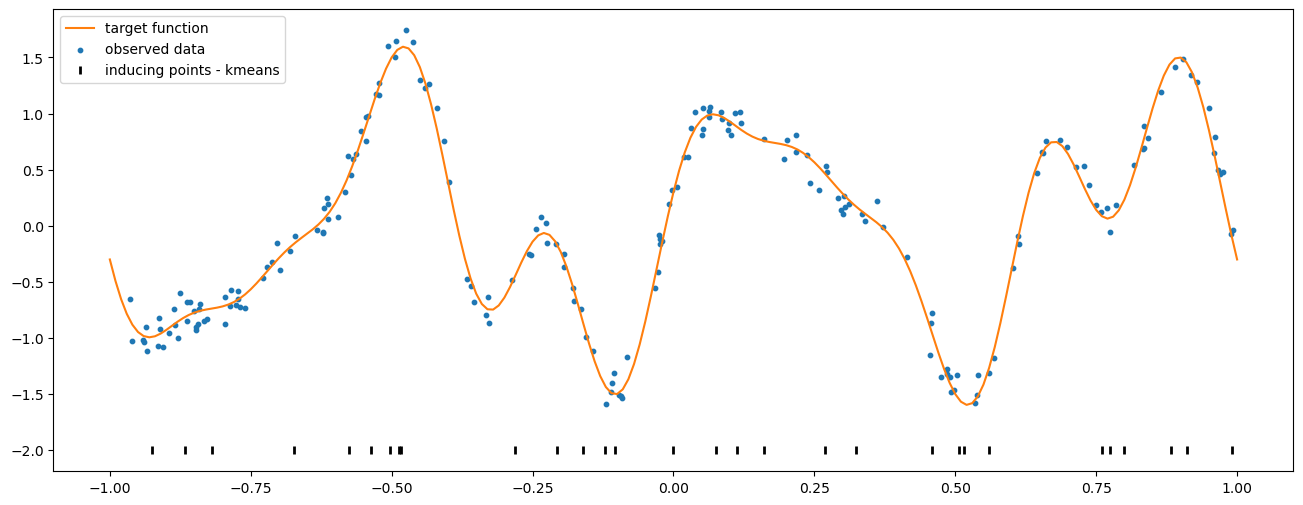

In [11]:
# plot
savename = "FIG_ANALYTIC/sparse1D_M30_kmeans_inducing.png"
plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(Z2, -2.0 * np.ones_like(Z2), "k|", mew=2, label="inducing points - kmeans")
plt.xlim([-1.1, 1.1])
plt.legend(loc=0)
plt.savefig(savename)
plt.show()

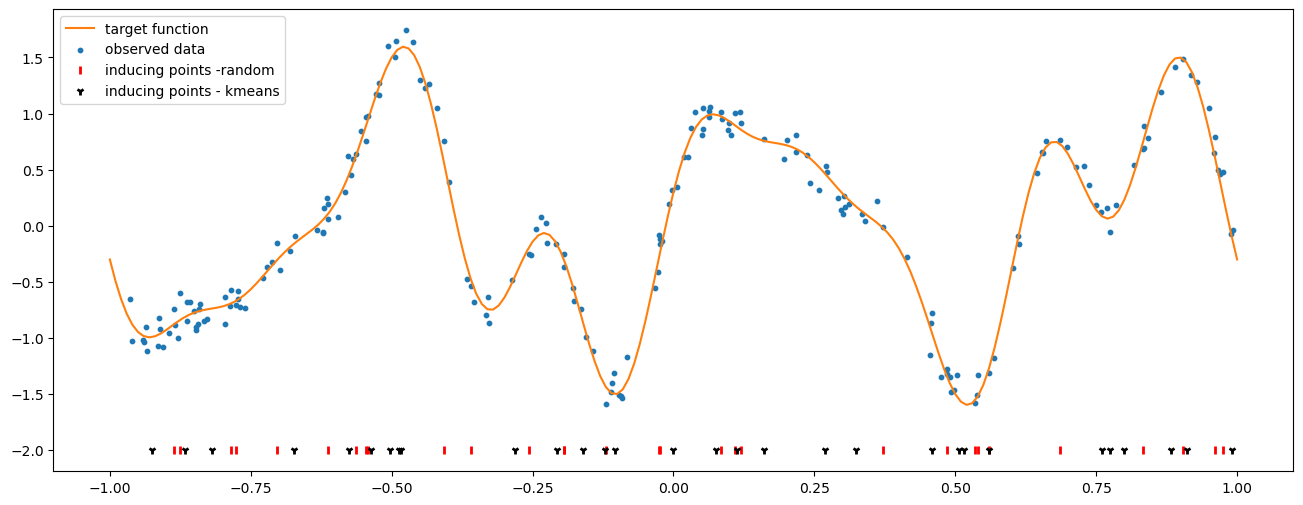

In [12]:
savename = "FIG_ANALYTIC/sparse1D_M30_random_kmeans_inducing.png"
plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(Z1, -2.0 * np.ones_like(Z1), "r|", mew=2, label="inducing points -random")
plt.plot(Z2, -2.0 * np.ones_like(Z2), "k1", mew=2, label="inducing points - kmeans")
plt.xlim([-1.1, 1.1])
plt.legend(loc=0)
plt.savefig(savename)
plt.show()

## 2 - Fit SGP model

### 2.1 SMT - FITC method

In order to ensure the proper convergence of optimization, we take an initial guess for theta based on the data std.\
Also, it can be useful to change the allowed bounds for this parameter.

In [13]:
# Initial guess for lengthscale parameter: standard deviation of training data
l = np.std(xt, axis=0)

# Transform to theta parameter (inverse of lengthscale)
theta = 1 / l**2
print("theta0 :", theta)

# Specify bounds for theta
bounds = [1e-8, 1e2]

theta0 : [2.94947077]


In [14]:
# Define model
sm = SGP(method="FITC", theta0=theta, theta_bounds=bounds, print_prediction=False)

# Assign training data and inducing inputs
sm.set_training_values(xt, yt)
sm.set_inducing_inputs(Z=Z1)

In [15]:
# Optimize
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1915638


In [16]:
# Print hyperparameters optimal values
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)
print("Reduced Loglikelihood :", sm.optimal_rlf_value)

sigma2 : 4.776492049048999
theta  : [37.03739559]
noise  : 0.010310568118994832
Reduced Loglikelihood : [[280.10874266]]


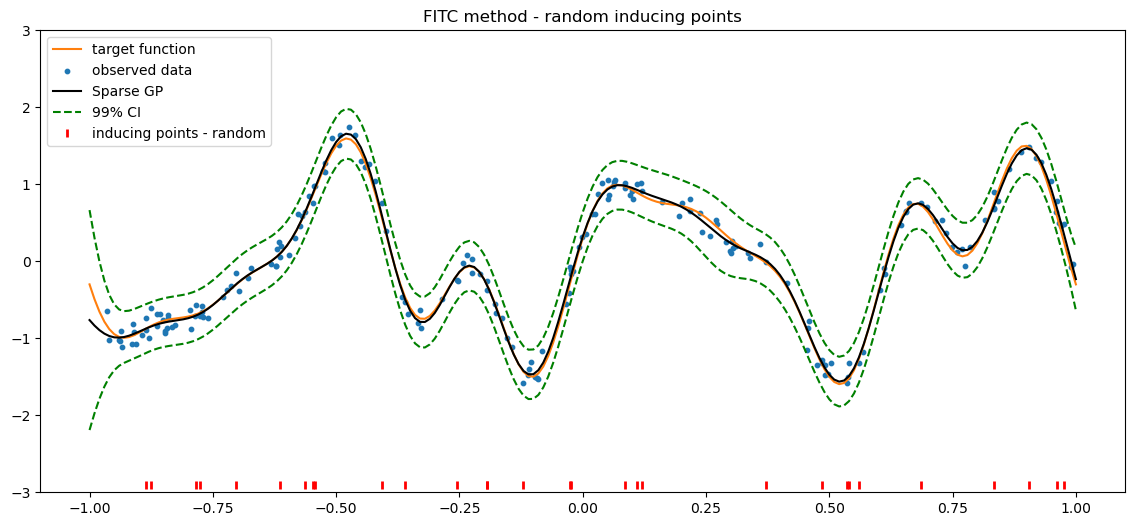

In [17]:
# to plot the function and the prediction
hat_y = sm.predict_values(x)
var = sm.predict_variances(x)

# plot prediction
savename = "FIG_ANALYTIC/sparse1D_M30_random_FITC.png"
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
plt.plot(Z1, -2.9 * np.ones_like(Z1), "r|", mew=2, label="inducing points - random")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title("FITC method - random inducing points")
plt.savefig(savename)
plt.show()

In [18]:
# Prediction on test set
Y_pred = sm.predict_values(xtest)
rmse = np.sqrt(np.mean((Y_pred.flatten() - ytest.flatten()) ** 2))
print("RMSE validation = %2.4f" % rmse)

RMSE validation = 0.1105


In [19]:
# Prediction on training data
Y_pred_train = sm.predict_values(xt)
rmse_train = np.sqrt(np.mean((Y_pred_train.flatten() - yt.flatten()) ** 2))
print("RMSE training = %2.4f" % rmse_train)

RMSE training = 0.0962


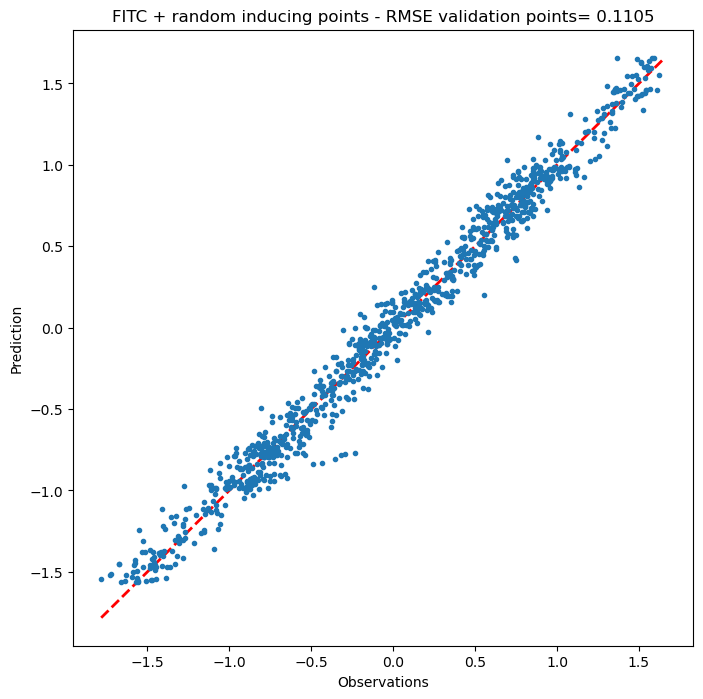

In [20]:
# Plot results
savename = "FIG_ANALYTIC/sparse1D_M30_random_FITC_pred_obs.png"
ymin = np.min([Y_pred, ytest])
ymax = np.max([Y_pred, ytest])
plt.figure(figsize=(8, 8))
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
plt.plot(ytest.flatten(), Y_pred.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("FITC + random inducing points - RMSE validation points= %.4f" % rmse)
plt.savefig(savename)
plt.show()

#### 2. K-means inducing inputs

In [21]:
sm2 = SGP(method="FITC", theta0=theta, theta_bounds=bounds, print_prediction=False)
sm2.set_training_values(xt, yt)
sm2.set_inducing_inputs(Z=Z2)
sm2.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1943631


In [22]:
print("sigma2 :", sm2.optimal_par["sigma2"])
print("theta  :", sm2.optimal_theta)
print("noise  :", sm2.optimal_noise)
print("Reduced Loglikelihood :", sm2.optimal_rlf_value)

sigma2 : 0.7027107120374713
theta  : [56.84468484]
noise  : 0.010234576667390548
Reduced Loglikelihood : [[282.99516722]]


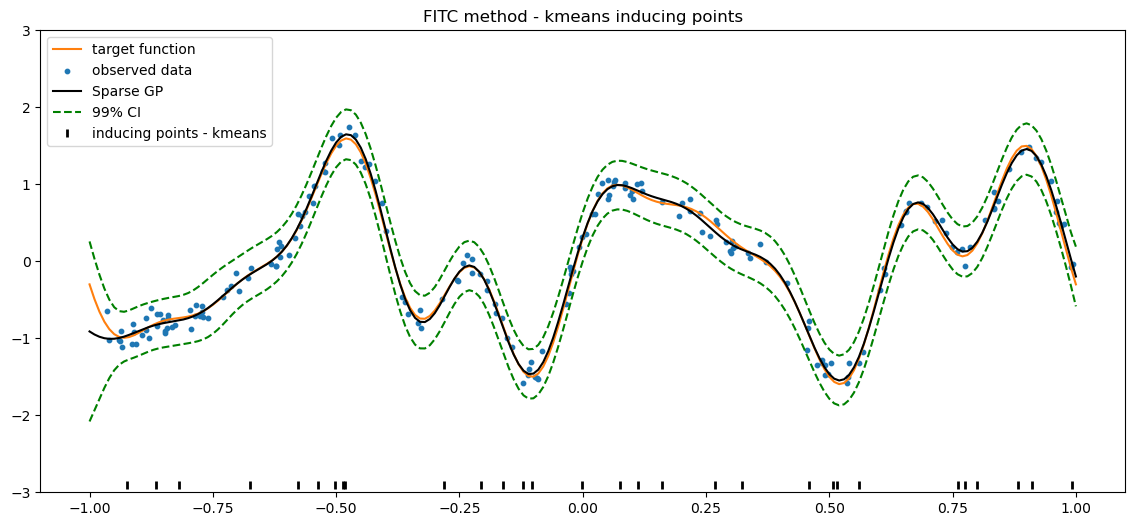

In [23]:
# to plot the function and the prediction
hat_y = sm2.predict_values(x)
var = sm2.predict_variances(x)

# plot prediction
savename = "FIG_ANALYTIC/sparse1D_M30_kmeans_FITC.png"
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
plt.plot(Z2, -2.9 * np.ones_like(Z2), "k|", mew=2, label="inducing points - kmeans")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title("FITC method - kmeans inducing points")
plt.savefig(savename)
plt.show()

RMSE validation = 0.1153


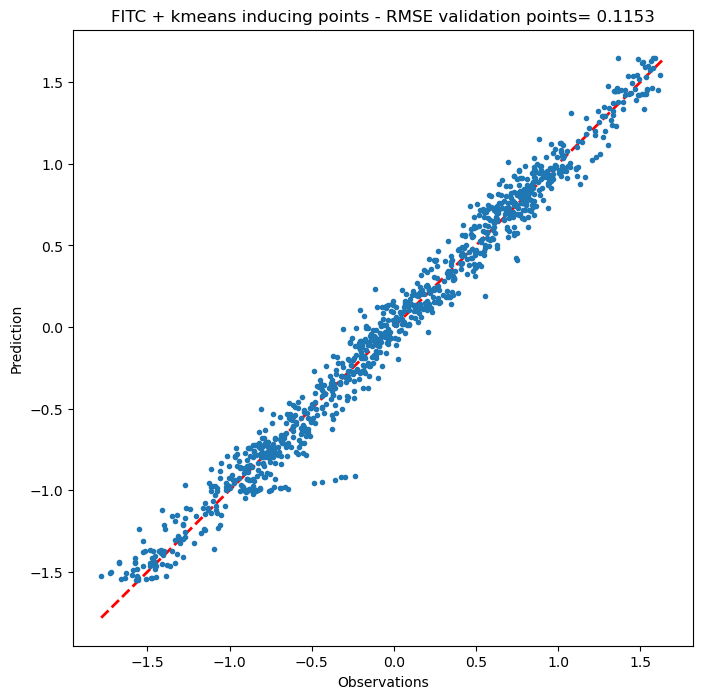

In [24]:
# Prediction on test set
Y_pred = sm2.predict_values(xtest)
rmse = np.sqrt(np.mean((Y_pred.flatten() - ytest.flatten()) ** 2))
print("RMSE validation = %2.4f" % rmse)
# Plot results
savename = "FIG_ANALYTIC/sparse1D_M30_kmeans_FITC_pred_obs.png"
ymin = np.min([Y_pred, ytest])
ymax = np.max([Y_pred, ytest])
plt.figure(figsize=(8, 8))
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
plt.plot(ytest.flatten(), Y_pred.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("FITC + kmeans inducing points - RMSE validation points= %.4f" % rmse)
plt.savefig(savename)
plt.show()

In [25]:
# Prediction on training data
Y_pred_train = sm2.predict_values(xt)
rmse_train = np.sqrt(np.mean((Y_pred_train.flatten() - yt.flatten()) ** 2))
print("RMSE training = %2.4f" % rmse_train)

RMSE training = 0.0966


### 2.2 SMT - VFE method

#### 1. Random inducing inputs

In [26]:
sm = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False)
sm.set_training_values(xt, yt)
sm.set_inducing_inputs(Z=Z1)
sm.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1825678


In [27]:
print("sigma2 :", sm.optimal_par["sigma2"])
print("theta  :", sm.optimal_theta)
print("noise  :", sm.optimal_noise)
print("Reduced Loglikelihood :", sm.optimal_rlf_value)

sigma2 : 0.8067216157751603
theta  : [44.79962984]
noise  : 0.012579176066901942
Reduced Loglikelihood : [[266.99396648]]


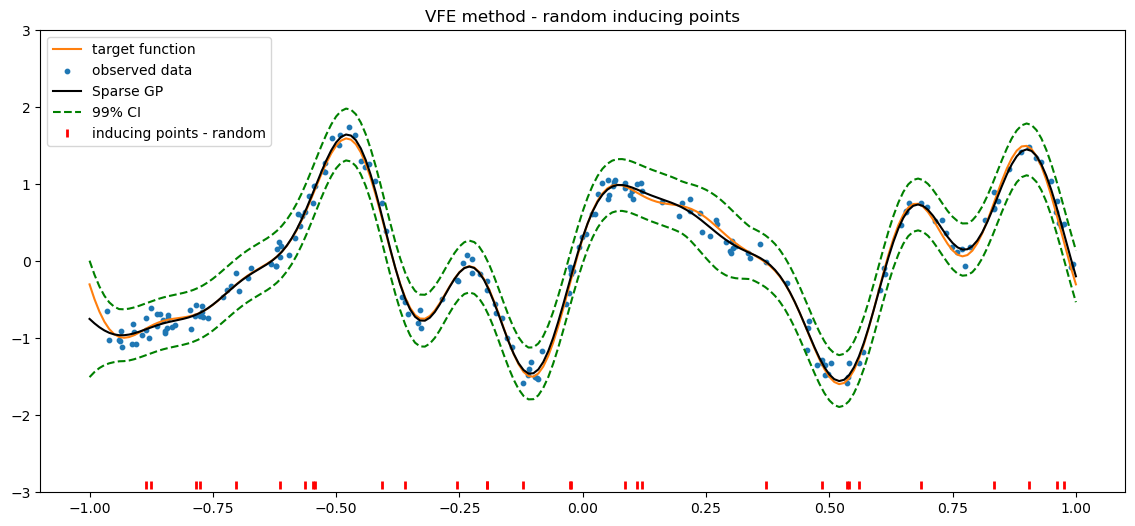

In [28]:
# to plot the function and the prediction
hat_y = sm.predict_values(x)
var = sm.predict_variances(x)

# plot prediction
savename = "FIG_ANALYTIC/sparse1D_M30_random_VFE.png"
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
plt.plot(Z1, -2.9 * np.ones_like(Z1), "r|", mew=2, label="inducing points - random")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title("VFE method - random inducing points")
plt.savefig(savename)
plt.show()

RMSE validation = 0.1092


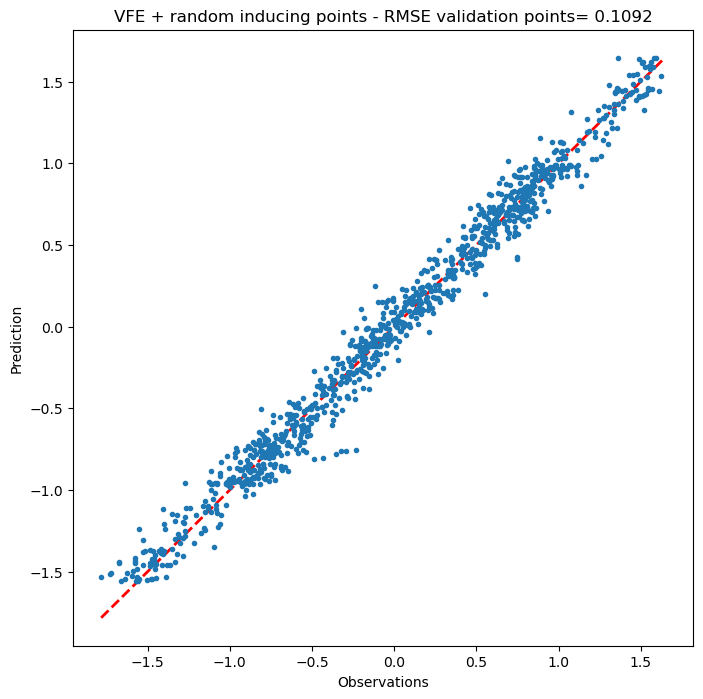

In [29]:
# Prediction on test set
Y_pred = sm.predict_values(xtest)
rmse = np.sqrt(np.mean((Y_pred.flatten() - ytest.flatten()) ** 2))
print("RMSE validation = %2.4f" % rmse)
# Plot results
savename = "FIG_ANALYTIC/sparse1D_M30_random_VFE_pred_obs.png"
ymin = np.min([Y_pred, ytest])
ymax = np.max([Y_pred, ytest])
plt.figure(figsize=(8, 8))
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
plt.plot(ytest.flatten(), Y_pred.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("VFE + random inducing points - RMSE validation points= %.4f" % rmse)
plt.savefig(savename)
plt.show()

In [30]:
# Prediction on training data
Y_pred_train = sm.predict_values(xt)
rmse_train = np.sqrt(np.mean((Y_pred_train.flatten() - yt.flatten()) ** 2))
print("RMSE training = %2.4f" % rmse_train)

RMSE training = 0.0969


#### 2. K-means inducing inputs

In [31]:
sm2 = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False)
sm2.set_training_values(xt, yt)
sm2.set_inducing_inputs(Z=Z2)
sm2.train()

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1818388


In [32]:
print("sigma2 :", sm2.optimal_par["sigma2"])
print("theta  :", sm2.optimal_theta)
print("noise  :", sm2.optimal_noise)
print("Reduced Loglikelihood :", sm2.optimal_rlf_value)

sigma2 : 0.803452027286402
theta  : [54.42259961]
noise  : 0.01274364414426088
Reduced Loglikelihood : [[276.62931459]]


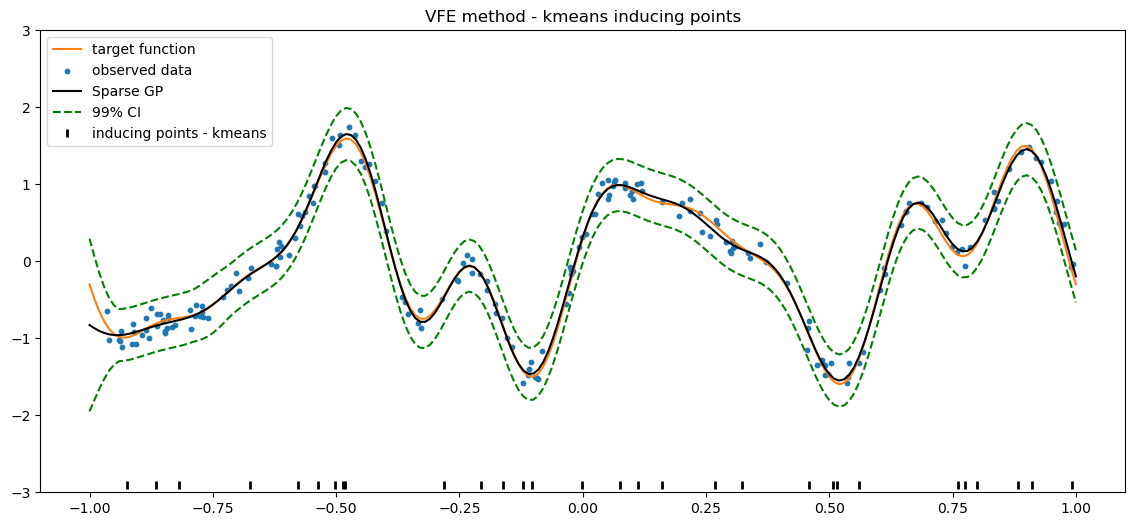

In [33]:
# to plot the function and the prediction
hat_y = sm2.predict_values(x)
var = sm2.predict_variances(x)

# plot prediction
savename = "FIG_ANALYTIC/sparse1D_M30_kmeans_VFE.png"
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
plt.plot(Z2, -2.9 * np.ones_like(Z2), "k|", mew=2, label="inducing points - kmeans")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title("VFE method - kmeans inducing points")
plt.savefig(savename)
plt.show()

RMSE validation= 0.1115


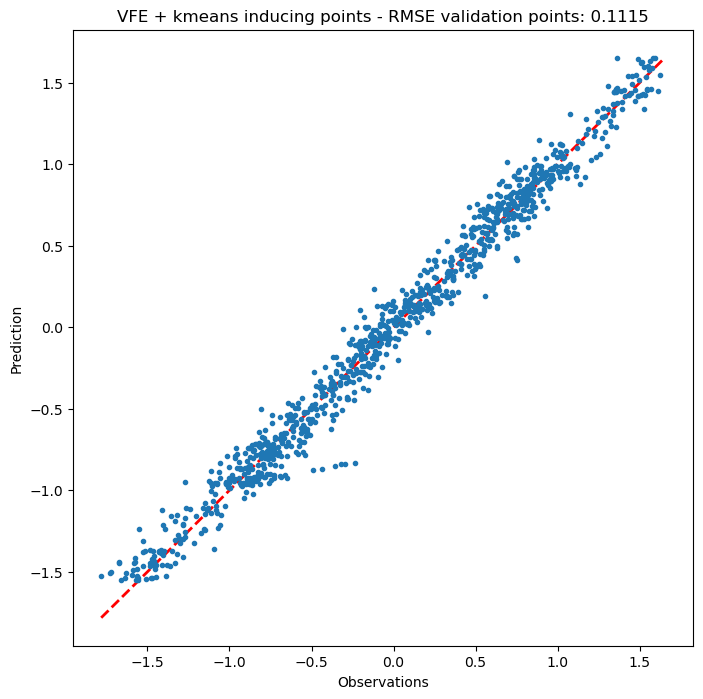

In [34]:
# Prediction on test set
Y_pred = sm2.predict_values(xtest)
rmse = np.sqrt(np.mean((Y_pred.flatten() - ytest.flatten()) ** 2))
print("RMSE validation= %2.4f" % rmse)
# Plot results
savename = "FIG_ANALYTIC/sparse1D_M30_kmeans_VFE_pred_obs.png"
ymin = np.min([Y_pred, ytest])
ymax = np.max([Y_pred, ytest])
plt.figure(figsize=(8, 8))
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
plt.plot(ytest.flatten(), Y_pred.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("VFE + kmeans inducing points - RMSE validation points: %.4f" % rmse)
plt.savefig(savename)
plt.show()

In [35]:
# Prediction on training data
Y_pred_train = sm2.predict_values(xt)
rmse_train = np.sqrt(np.mean((Y_pred_train.flatten() - yt.flatten()) ** 2))
print("RMSE training = %2.4f" % rmse_train)

RMSE training = 0.0964


## 3- Comparison with full GP and SVGP

We recall that we have the following dimensions for the training set:

In [36]:
xt.shape

(200, 1)

As the standard GP model implies a memory cost of $\mathcal{O}(N^2)$ and an inference cost of $\mathcal{O}(N^3)$. This would lead us to the corresponding scales:

In [37]:
print("Memory cost: ~ %i values" % (xt.shape[0] ** 2))
print(
    "Considering float32, memory required: ~ %.2f Go" % (4 * xt.shape[0] ** 2 / 1024**3)
)
print(
    "Considering float64, memory required: ~ %.2f Go" % (8 * xt.shape[0] ** 2 / 1024**3)
)
print(f"Inference cost: ~ {xt.shape[0]**3:.2e} operations")

Memory cost: ~ 40000 values
Considering float32, memory required: ~ 0.00 Go
Considering float64, memory required: ~ 0.00 Go
Inference cost: ~ 8.00e+06 operations


Here, considering $M=100$ inducing points, the SGP model only implies a memory cost of $\mathcal{O}(NM)$ and an inference cost of $\mathcal{O}(NM^2)$.\
This would lead us to the corresponding scales:

In [38]:
print("Memory cost: ~ %i values" % (50 * xt.shape[0]))
print(
    "Considering float32, memory required: ~ %.2f Mo" % (4 * 50 * xt.shape[0] / 1024**2)
)
print(
    "Considering float64, memory required: ~ %.2f Mo" % (8 * 50 * xt.shape[0] / 1024**2)
)
print(f"Inference cost: ~ {xt.shape[0]*50**2:.2e} operations")

Memory cost: ~ 10000 values
Considering float32, memory required: ~ 0.04 Mo
Considering float64, memory required: ~ 0.08 Mo
Inference cost: ~ 5.00e+05 operations


In [55]:
# Define and train SMT KRG model
smt_model = KRG(
    eval_noise=True, theta0=theta, theta_bounds=bounds, print_prediction=False
)
smt_model.set_training_values(xt, yt)
smt_model.train()

# Predict
hat_y = smt_model.predict_values(x)
var = smt_model.predict_variances(x)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.4153664


In [56]:
print("sigma2 :", smt_model.optimal_par["sigma2"])
print("theta  :", smt_model.optimal_theta)
print("noise  :", smt_model.optimal_noise)
print("Reduced Loglikelihood :", smt_model.optimal_rlf_value)

sigma2 : [0.87708587]
theta  : [20.9647365]
noise  : 0.011999158559594872
Reduced Loglikelihood : 303.9045228970302


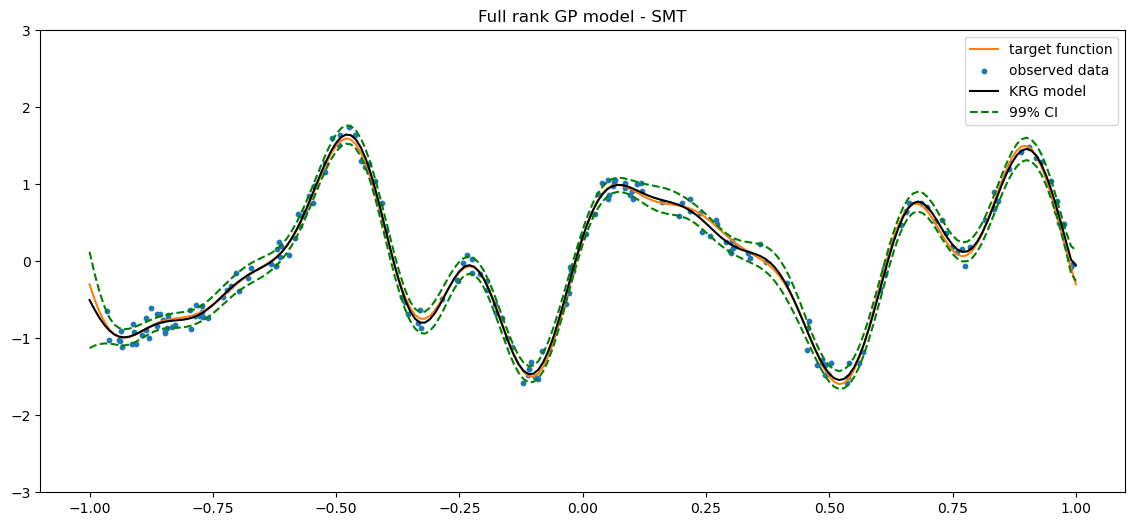

In [57]:
# plot prediction
savename = "FIG_ANALYTIC/sparse1D_fullGP.png"
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="KRG model")
plt.plot(x, hat_y - 3 * np.sqrt(var), "g--")
plt.plot(x, hat_y + 3 * np.sqrt(var), "g--", label="99% CI")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title("Full rank GP model - SMT")
plt.savefig(savename)
plt.show()

RMSE validation= 0.1050


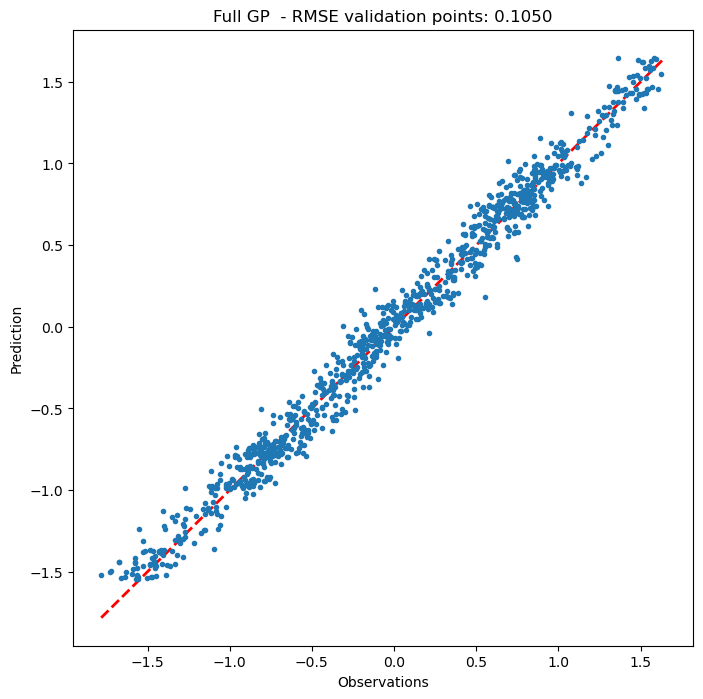

In [58]:
# Prediction on test set
Y_pred = smt_model.predict_values(xtest)
rmse = np.sqrt(np.mean((Y_pred.flatten() - ytest.flatten()) ** 2))
print("RMSE validation= %2.4f" % rmse)
# Plot results
savename = "FIG_ANALYTIC/sparse1D_fullGP_pred_obs.png"
ymin = np.min([Y_pred, ytest])
ymax = np.max([Y_pred, ytest])
plt.figure(figsize=(8, 8))
plt.plot([ymin, ymax], [ymin, ymax], "r--", linewidth=2)
plt.plot(ytest.flatten(), Y_pred.flatten(), ".")
plt.xlabel("Observations")
plt.ylabel("Prediction")
plt.title("Full GP  - RMSE validation points: %.4f" % rmse)
plt.savefig(savename)
plt.show()

In [59]:
# Prediction on training data
Y_pred_train = smt_model.predict_values(xt)
rmse_train = np.sqrt(np.mean((Y_pred_train.flatten() - yt.flatten()) ** 2))
print("RMSE training = %2.4f" % rmse_train)

RMSE training = 0.0945


### For a large number of observations - time  \& memory

In [43]:
N_range = np.linspace(20, 2000, 20).astype(int)
sgp_time = []
krg_time = []

for N in N_range:
    # generate data
    X = 2 * np.random.rand(N, 1) - 1
    Y = f_obj(X) + rng.normal(loc=0.0, scale=np.sqrt(eta), size=(N, 1))

    # number of inducing points = 10 % of the data set
    n_inducing = np.int(0.1 * N)
    random_idx = rng.permutation(N)[:n_inducing]
    Z = X[random_idx].copy()

    # fit SGP model - VFE
    start = time.time()
    sgp = SGP(method="VFE", print_prediction=False)
    # sgp = SGP(method="VFE", theta0=theta, theta_bounds=bounds, print_prediction=False)
    sgp.set_training_values(X, Y)
    sgp.set_inducing_inputs(Z=Z1)
    sgp.train()
    sgp_time.append(time.time() - start)

    # fit KRG model
    start = time.time()
    smt_model = KRG(eval_noise=True, print_global=False)
    smt_model.set_training_values(X, Y)
    smt_model.train()
    krg_time.append(time.time() - start)

___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1520736
___________________________________________________________________________
   
                                    SGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 124
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1628969
___________________________________________________________________________
   
                                    SGP
_______________________________________________________

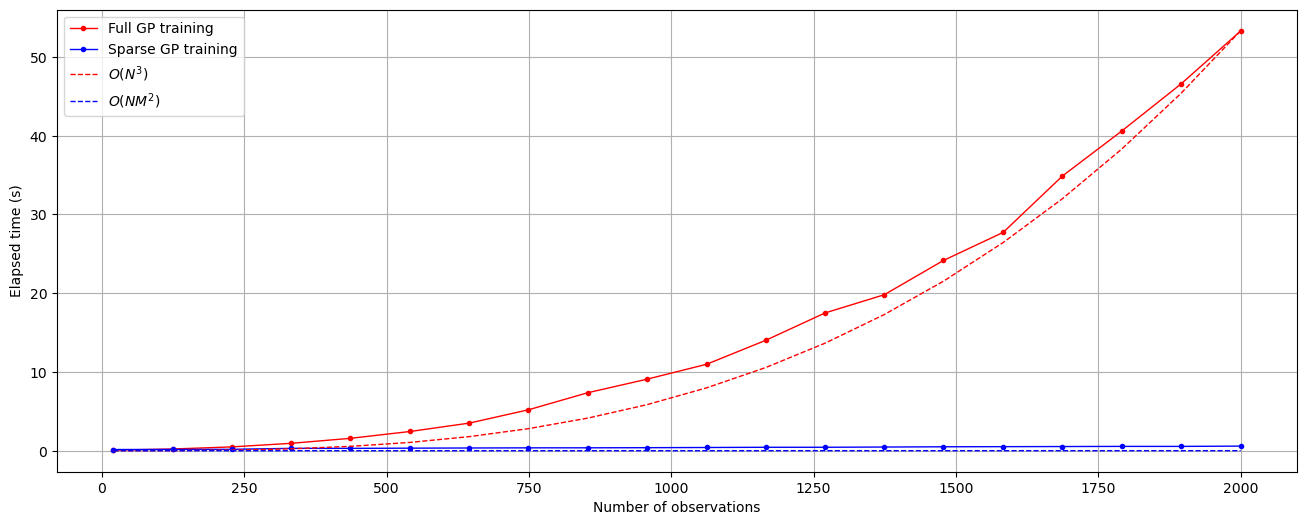

In [47]:
cst = (
    1 / 1.5e8
)  # time needed for 1 operation (in seconds), to be adjusted to fit the experimental curve!
savename = "FIG_ANALYTIC/sparse1D_cv_time_memory.png"
ymin = np.min([Y_pred, ytest])
plt.figure(figsize=(16, 6))
plt.plot(N_range, krg_time, "r.-", label="Full GP training", linewidth=1)
plt.plot(N_range, sgp_time, "b.-", label="Sparse GP training", linewidth=1)
plt.plot(
    N_range, cst * N_range.astype(float) ** 3, "r--", label=r"$O(N^3)$", linewidth=1
)
plt.plot(
    N_range, cst * N_range.astype(float) * 10**2, "b--", label=r"$O(NM^2)$", linewidth=1
)
plt.xlabel("Number of observations")
plt.ylabel("Elapsed time (s)")
plt.legend()
plt.grid()
plt.savefig(savename)
plt.show()